## Linear Regression with CNN Features on Cars

This notebook contains our linear regression model for price prediction on the Cars dataset.

We generate CNN features using the VGG-16 network, and reduce their dimensionality using PCA.

We then train linear regression on the training set, and report evaluation metrics on the test set.

### Imports

In [1]:
import tensorflow as tf

import yaml

from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

import csv

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os

from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Extract and Save Features

We run the dataset through VGG-16, extracting the activations of the last feature layer as our high-dimensional feature vectors. We then reduce the dimensionality using PCA.

In [4]:
data_path = "../datasets/"
model = VGG16(weights='imagenet', include_top=False)

cnn_feats = np.zeros((1478, 512 * 7 * 7))

im_prices = np.zeros(1478)

with open(data_path + "cars_filtered.csv", "r") as file:
    i = -1
    for line in file:
        i += 1
        line_arr = line.split(',')
        img_path = data_path + 'cars_im/' + line_arr[0] + '.jpg'
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)

        # Reshape features into 2D tensor
        reshaped_features = features.reshape(1, 512*7*7)
        cnn_feats[i, :] = reshaped_features
        
        im_prices[i] = int(line_arr[3])
        
        if i % 1000 == 0:
            print(i)

print(cnn_feats.shape)

# reduce dimensionality using principal components analysis (PCA)

pca = PCA(n_components=256)
pca.fit(cnn_feats)
cnn_feats_compressed = pca.transform(cnn_feats)

np.save("car_linreg_cnn_pca_components", pca.components_)
np.save("car_linreg_cnn_pca_features", cnn_feats_compressed)

0
1000
(1478, 25088)


### Linear Regression using CNN Features

We train linear regression on the PCA-processed CNN features on our training split, then evaluate on the test split.

We report three different metrics: MSE (mean squared error), MAE (mean absolute error), and R^2 (coefficient of determination)

In [5]:
# Load training and eval data
cnn_feats_compressed = np.load("car_linreg_cnn_pca_features.npy")

train_inds = np.load('cars_train_indices.npy')
test_inds = np.load('cars_test_indices.npy')

train_data = cnn_feats_compressed[train_inds]
train_labels = im_prices[train_inds]

test_data = cnn_feats_compressed[test_inds]
test_labels = im_prices[test_inds]


regr = linear_model.LinearRegression()

regr.fit(train_data, train_labels)

predicted = regr.predict(test_data)

# Metrics
MSE = mean_squared_error(test_labels, predicted)
MAE = mean_absolute_error(test_labels, predicted)
R2 = r2_score(test_labels, predicted)

print("Mean squared error: %.2f" % MSE)
print("Mean absolute error: %.2f" % MAE)
print('Coefficient of determination: %.2f' % R2)

Mean squared error: 1429508327.10
Mean absolute error: 23929.67
Coefficient of determination: 0.75


### Error plot

Plot the per-example absolute error.

In [6]:
error = []
for a,b in zip(test_labels, predicted):
    error.append((np.abs(a - b), a, b))
error.sort(key=lambda x: x[0])

error_x = range(len(error))
error_val = []
error_y_label = []
error_y_pred = []
for e in error:
    error_val.append(e[0])
    error_y_label.append(e[1])
    error_y_pred.append(e[2])

Text(0,0.5,'Absolute Error')

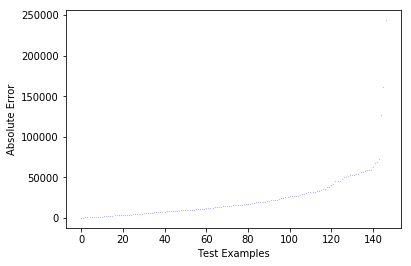

In [7]:
plt.scatter(error_x, error_val,  color='blue', s=0.01)
plt.xlabel('Test Examples')
plt.ylabel('Absolute Error')